# Retail Store Inventory Forecasting

This notebook provides a basic framework for building and evaluating different regression models (Random Forest, Linear Regression, LSTM, XGBoost) for a potential inventory forecasting task. 

It demonstrates common steps in a machine learning workflow, including data preprocessing, model training, evaluation, and visualization.

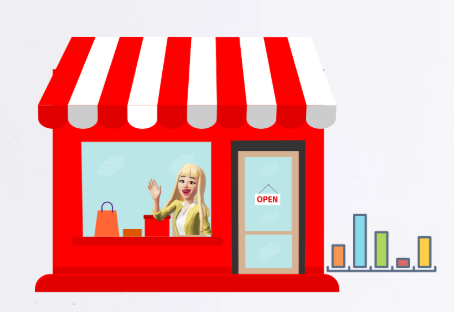

****This forecasting helps retailers maintain optimal inventory levels, reduce the cost of overstocking, and meet customer demands!abs****

# * Data Loading and Exploration

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# For training a Random Forest regression model.
from sklearn.ensemble import RandomForestRegressor

# For scaling data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

# For splitting data into training and testing sets.
from sklearn.model_selection import train_test_split

# For splitting data into training and testing sets.
from tensorflow.keras.models import Sequential

# For combining predictions from multiple regression models.
from sklearn.ensemble import VotingRegressor

# For training a linear regression model.
from sklearn.linear_model import LinearRegression

# from sklearn.preprocessing import MinMaxScaler

# For creating LSTM layers, fully connected layers, and dropout layers for the neural network.
from tensorflow.keras.layers import LSTM, Dense, Dropout

# For optimizing the neural network's weights during training.
from tensorflow.keras.optimizers import Adam

# For stopping the training process early to prevent overfitting.
from tensorflow.keras.callbacks import EarlyStopping

# For standardizing data (mean 0, standard deviation 1).
from sklearn.preprocessing import StandardScaler

# For evaluating model performance using common metrics.
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For training an XGBoost regression model.
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
# Load the dataset
file_path = '/kaggle/input/retail-store-inventory-forecasting-dataset/retail_store_inventory.csv'
df = pd.read_csv(file_path)

# quick initial inspection of the loaded data.
df.head()

In [ ]:
# List the Indexes of the data frame 
df.columns



Inventory levels are the number of goods a company has across its entire logistics or distribution network. This metric includes the quantity of stock located in warehouses, logistics centres, and physical stores.

"Seasonality" refers to predictable fluctuations in demand for products or services throughout the year.

In [ ]:
# data frame structure and contents 
print(df.info())

In [ ]:
print("\nSummary Statistics for Numerical Columns:")

# Descriptive statistics for all numerical columns in the DataFrame
print(df.describe())

In [ ]:
#check null
print("\nMissing Values:")
print(df.isnull().sum())

# good thing, no missing values 

In [ ]:


# Get the list of categrical columns in the data frame
categorical_columns=df.select_dtypes(include=['object']).columns

# dispay frequency count for categorical columns
for col in categorical_columns:
    print(f"\nFrequency counts for {col}:")
    print(df[col].value_counts())
    print(f"Percentage distribution for {col}:")
                                              

In [ ]:
print("\nAdditional Statistics:")
print(f"Total number of stores       :{df['Store ID'].nunique()}")
print(f"Total number of products     :{df['Product ID'].nunique()}")
print(f"Date range                   :from {df['Date'].min()} to {df['Date'].max()}")

In [ ]:
# Aggregate data by date

# convert data to datetime (format: 2022-01-01 YYYY-MM-DD)
df['Date']= pd.to_datetime(df['Date'])

# Daily Sales Calculation
# daily_sales now has a 'Date' column and a 'Units Sold' column representing the total units sold on each day.
daily_sales = df.groupby('Date')['Units Sold'].sum().reset_index()

# Plot daily sales
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['Date'], daily_sales['Units Sold'])
plt.title('Time series plot of daily sales')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

In [ ]:

plt.figure(figsize=(10, 6))

# calculates the frequency distribution of the values in the 'Units Sold' column
plt.hist(df['Units Sold'], bins=30)

plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# the spread of prices (interquartile range), and potential outliers. 
sns.boxplot(x=df['Price'])
plt.title('Box Plot of Price')
plt.show()

# **Exploratory Data Analysis (EDA)**

In [ ]:
# Calculating Monthly Sales
monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Units Sold'].sum().reset_index()

monthly_sales['Date'] = monthly_sales['Date'].dt.to_timestamp()

# Plotting Monthly Sales Trend
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Date'], monthly_sales['Units Sold'])
plt.title('Monthly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.show()

In [ ]:
# Identifying Numerical Columns:
numeric_columns = df.select_dtypes(include=[np.number]).columns

# This line calculates the correlation coefficients between all pairs of numerical columns 
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


# Challenge 1: Time Series Demand Forecasting

In [ ]:
# sort in ascending order
df = df.sort_values('Date')

daily_sales = df.groupby('Date')['Units Sold'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

In [ ]:
# Feature engineering: add day of week and month

# creates a new column named DayOfWeek in the daily_sales DataFrame
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek

# creates another new column named Month in the daily_sales DataFrame
daily_sales['Month'] = daily_sales.index.month

In [ ]:
# Normalize the data before running the models 
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(daily_sales)


In [ ]:
# Create sequences with multiple features
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])  # Target is 'Units Sold'
    return np.array(X), np.array(y)

seq_length = 60  # Increased sequence length for better context
X, y = create_sequences(sales_scaled, seq_length)

In [ ]:
# Split the data into training and testing sets using scikit-learn
# X: Features
# y: Units Sold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Build the LSTM (Long Short-Term Memory) model using tensorflow.keras.models
# model = Sequential([
#     LSTM(100, activation='relu', return_sequences=True, input_shape=(seq_length, X.shape[2])),
#     Dropout(0.2),
#     LSTM(100, activation='relu'),
#     Dropout(0.2),
#     Dense(50, activation='relu'),
#     Dense(1)  # Output layer for predicting Units Sold
# ])


##### 

from tensorflow.keras.layers import Input, LSTM, Dropout, Dense

# Define the input shape
input_shape = (seq_length, X.shape[2])  # Assuming X.shape[2] represents the number of features

# Create the model
model = Sequential([
  Input(shape=input_shape),  # First layer is Input with the defined shape
  LSTM(100, activation='relu', return_sequences=True),
  Dropout(0.2),
  LSTM(100, activation='relu'),
  Dropout(0.2),
  Dense(50, activation='relu'),
  Dense(1)
])

In [ ]:
# Compile the model with a custom learning rate

# creates an optimizer object of the Adam type, which is a popular optimization algorithm for training neural networks.
optimizer = Adam(learning_rate=0.001)

# compiles the LSTM model you defined earlier
model.compile(optimizer=optimizer, loss='mse')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=200, # The number of training epochs (iterations over the entire training data).
    batch_size=32, # The number of samples used for each training update.
    validation_split=0.1, # Allocates 10% of the training data for validation (used by the EarlyStopping callback).
    callbacks=[early_stopping],
    verbose=1
)

# Make predictions on the test set
lstm_predictions = model.predict(X_test)

# Inverse transform the predictions and actual values correctly
# We need to create a full feature set for inverse transformation.
lstm_predictions_full = np.column_stack((lstm_predictions, np.zeros((lstm_predictions.shape[0], X.shape[2] - 1))))
y_test_full = np.column_stack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X.shape[2] - 1))))

lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions_full)[:, 0]
y_test_actual_inverse = scaler.inverse_transform(y_test_full)[:, 0]

# Calculate Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) metrics for LSTM predictions
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual_inverse, lstm_predictions_inverse))
lstm_mae = mean_absolute_error(y_test_actual_inverse, lstm_predictions_inverse)

print("LSTM RMSE:", lstm_rmse)
print("LSTM MAE:", lstm_mae)

In [ ]:

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual_inverse, label='Actual')
plt.plot(lstm_predictions_inverse, label='LSTM Predictions')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Plot the training history to visualize loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RMSE and MAE values around 911 and 729 respectively may indicate reasonable (moderate) predictive accuracy 
, continuous improvement through experimentation and validation is always beneficial. 

Initial Loss: The initial loss value (0.1203) is relatively high, indicating that the model initially struggled to make accurate predictions.

# Challenge 2: Inventory Optimization

**To get result of demand forcasting challenge, start feature enginnering then model with random forest and XGBoost Separately and finally with Ensemble prediction methods I got better result that would be improve **

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Inventory Level', data=df)
plt.title('Inventory Level Over Time')
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Units Sold', y='Inventory Level', data=df)
plt.title('Inventory Level vs Units Sold')
plt.show()

In [ ]:
# Calculate stockout (a situation where a company runs out of a particular product or item that is in demand) frequency
stockout_freq = (df['Inventory Level'] == 0).mean()
print(f"Stockout frequency: {stockout_freq:.2%}")

In [ ]:
# Calculate overstock frequency 

# calculates the average daily sales across the entire dataset
avg_daily_sales = df.groupby('Date')['Units Sold'].mean().mean()

#  line calculates the frequency of overstock occurrences

# "overstock" is defined as a situation where the current inventory level exceeds twice the average daily sales.
overstock_freq = (df['Inventory Level'] > 2 * avg_daily_sales).mean()

print(f"Overstock frequency: {overstock_freq:.2%}")

In [ ]:
# Sort the DataFrame by date and store/product ID to ensure correct lag and rolling calculations
df = df.sort_values(['Store ID', 'Product ID', 'Date'])

# Create lag features
for lag in [1, 7]:
    df[f'Sales_Lag_{lag}'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].shift(lag)

# Create rolling mean features
for window in [7, 14]:
    df[f'Sales_RollingMean_{window}'] = df.groupby(['Store ID', 'Product ID'])['Units Sold'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

# Add day of week and month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

# Handle missing values
df = df.dropna()

# Print the shape of the DataFrame before and after dropping NA values
print(f"Shape before dropping NA: {df.shape}")
print(f"Shape after dropping NA: {df.shape}")

# Check the created features
print(df[['Units Sold'] + [f'Sales_Lag_{lag}' for lag in [1, 7]] + [f'Sales_RollingMean_{window}' for window in [7, 14]] + ['DayOfWeek', 'Month']].head())

In [ ]:
# Feature engineering using Random Forest Regressor to predict future sales 

# Prepare features and target
features = ['Sales_Lag_1', 'Sales_Lag_7', 'Sales_RollingMean_7', 'DayOfWeek', 'Month', 'Price', 'Discount']
X = df[features]
y = df['Units Sold']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

# TODO Evaluate the result: Mean Squared Error: 10406.44
# "Units Solds" usually less than 100. Hence, this MSE signifies that the model was not good

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Calculate additional metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared Score: {r2:.2f}")

# Visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Actual vs Predicted Units Sold")
plt.show()

# Feature importance
importances = rf_model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(importances, features)), columns=['Value','Feature'])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Random Forest Features Importance')
plt.tight_layout()
plt.show()

# TODO evaluate the result 
# Mean Absolute Error: 82.69 -> too big 
# R-squared Score: 0.12

# TODO
# The graphs show the prediction looks wrong

TODO: Feature dicscount Dayof week are less important?

In [ ]:
# Prepare features and target
features = ['Sales_Lag_1', 'Sales_Lag_7', 'Sales_RollingMean_7', 'DayOfWeek', 'Month', 'Price', 'Discount']
X = df[features]
y = df['Units Sold']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training an XGBoost Model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("\nXGBoost Results:")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}")
print(f"R-squared: {r2_score(y_test, y_pred_xgb):.2f}")

# TODO Evaluate the result 
# XGBoost Results:
# MSE: 10361.02 -> too big 
# R-squared: 0.12 -> bad 

# an MSE of 10361.02 suggests that, on average, the squared difference between the predicted and actual sales is around 10361 units.
# An R-squared of 0.12 means that the XGBoost model only explains about 12% of the variation in 'Units Sold'.

In [ ]:

# Prepare the data again
X = df[features]
y = df['Units Sold']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Create and fit the ensemble
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(random_state=42)
lr_model = LinearRegression()

In [ ]:
ensemble = VotingRegressor(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('lr', lr_model)],
    weights=[2, 2, 1]
)

In [ ]:

ensemble.fit(X_train, y_train)

# Make predictions
y_pred_ensemble = ensemble.predict(X_test)

In [ ]:
# Evaluate the ensemble model
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
r2_ensemble = r2_score(y_test, y_pred_ensemble)

print("Ensemble Model Results (original features):")
print(f"MSE: {mse_ensemble:.2f}")
print(f"R-squared: {r2_ensemble:.2f}")


* ****MSE (Mean Squared Error):
*
*
* Previous XGBoost model: 10361.02
*
*
* New Ensemble model: 10095.35
*
*
* This represents a decrease in MSE of about 2.6%, which is a modest improvement.
*
*
* R-squared:Previous models: 0.12
*
* New Ensemble model: 0.14

vement,